In [ ]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
from scandataset import SCANDataset
from scandataloader import SCANDataLoader
from transformer import Transformer
import tqdm
import numpy as np
import matplotlib.pyplot as plt
from hyperparam_config.hyperparam_exp23 import *

In [ ]:
device = 'mps' if torch.backends.mps.is_available() else ('cuda' if torch.cuda.is_available() else 'cpu')

device

'cuda'

In [ ]:
MAX_LEN = 50
NR_REPS = 5
NR_NUM = 6

src_vocab = [
    '<PAD>',
    '<BOS>',
    '<EOS>',
    'walk',
    'look',
    'run',
    'jump',
    'turn',
    'left',
    'right',
    'and',
    'after',
    'opposite',
    'twice',
    'thrice',
    'around',
]

tgt_vocab = [
    '<PAD>',
    '<BOS>',
    '<EOS>',
    'I_WALK',
    'I_RUN',
    'I_JUMP',
    'I_LOOK',
    'I_TURN_RIGHT',
    'I_TURN_LEFT'
]

def list_to_dict(lst):
    return {k: v for v, k in enumerate(lst)}

src_vocab = list_to_dict(src_vocab)
tgt_vocab = list_to_dict(tgt_vocab)

scandataloader = SCANDataLoader()
data = []

data.append((
    scandataloader.load_file_path(
        os.path.join('data', 'add_prim_split', f'tasks_train_addprim_turn_left.txt')
    ),
    scandataloader.load_file_path(
        os.path.join('data', 'add_prim_split', f'tasks_test_addprim_turn_left.txt')
    )
))

data.append((
    scandataloader.load_file_path(
        os.path.join('data', 'add_prim_split', f'tasks_train_addprim_jump.txt')
    ),
    scandataloader.load_file_path(
        os.path.join('data', 'add_prim_split', f'tasks_test_addprim_jump.txt')
    )
))

for exponent in range(NR_NUM):
    pow2 = 2**exponent
    train_paths = []
    test_paths = []
    for i in range(1, NR_REPS + 1):
        data.append((
            scandataloader.load_file_path(os.path.join(
                'data',
                'add_prim_split',
                'with_additional_examples',
                f'tasks_train_addprim_complex_jump_num{pow2}_rep{i}.txt')
        ),
            scandataloader.load_file_path(os.path.join(
                'data',
                'add_prim_split',
                'with_additional_examples',
                f'tasks_test_addprim_complex_jump_num{pow2}_rep{i}.txt')
        )
        ))


In [ ]:
def train_loop(model, optimizer, criterion, dataloader, epochs):
    model.train()

    for epoch in tqdm.tqdm(range(epochs)):
        total_loss = 0
        for batch in dataloader:
            src = batch['src'].to(device)
            tgt = batch['tgt'].to(device)

            tgt_input = tgt[:, :-1]
            tgt_output = tgt[:, 1:]

            output = model(src, tgt_input)

            output = output.view(-1, output.shape[-1])
            tgt_output = tgt_output.reshape(-1)

            loss = criterion(output, tgt_output)

            optimizer.zero_grad()
            loss.backward()
            nn.utils.clip_grad_norm_(model.parameters(), GRAD_CLIP)
            optimizer.step()

            total_loss += loss.item()

        print(f"Epoch {epoch + 1}, Loss: {total_loss/len(dataloader):.4f}")

In [ ]:
def eval_loop(model, dataloader):
    model.eval()

    special_tokens = [tgt_vocab['<PAD>'], tgt_vocab['<BOS>'], tgt_vocab['<EOS>']]

    start_token = tgt_vocab['<BOS>']
    end_token = tgt_vocab['<EOS>']

    total_tokens = 0
    correct_tokens = 0
    total_seq = 0
    correct_seq = 0

    with torch.no_grad():
        for batch in dataloader:
            src = batch['src'].to(device)
            tgt = batch['tgt'].to(device)

            output = model.predict(src, start_token, end_token, MAX_LEN)

            for i in range(output.size(0)):
                tgt_tokens = tgt[i].cpu().numpy()
                pred_tokens = output[i].cpu().numpy()

                for t, p in zip(tgt_tokens, pred_tokens):
                    if t not in special_tokens:
                        total_tokens += 1
                        if t == p:
                            correct_tokens += 1

                if all(t == p for t, p in zip(tgt_tokens, pred_tokens) if t not in special_tokens):
                    correct_seq += 1
                total_seq += 1

    token_accuracy = correct_tokens / total_tokens
    seq_accuracy = correct_seq / total_seq

    return token_accuracy, seq_accuracy


def eval_loop_new_seq_calc(model, dataloader):
    model.eval()

    special_tokens = [tgt_vocab['<PAD>'], tgt_vocab['<BOS>'], tgt_vocab['<EOS>']]

    start_token = tgt_vocab['<BOS>']
    end_token = tgt_vocab['<EOS>']

    total_tokens = 0
    correct_tokens = 0
    total_seq = 0
    correct_seq = 0

    with torch.no_grad():
        for batch in dataloader:
            src = batch['src'].to(device)
            tgt = batch['tgt'].to(device)

            output = model.predict(src, start_token, end_token, MAX_LEN)

            for i in range(output.size(0)):
                tgt_tokens = tgt[i].cpu().numpy()
                pred_tokens = output[i].cpu().numpy()

                for t, p in zip(tgt_tokens, pred_tokens):
                    if t not in special_tokens:
                        total_tokens += 1
                        if t == p:
                            correct_tokens += 1
                    if p == tgt_vocab['<EOS>']:
                        break

                tgt_seq = tgt_tokens.tolist()
                pred_seq = pred_tokens.tolist()
                if tgt_vocab['<EOS>'] in pred_seq:
                    pred_seq = pred_seq[:pred_seq.index(tgt_vocab['<EOS>']) + 1]
                if tgt_vocab['<EOS>'] in tgt_seq:
                    tgt_seq = tgt_seq[:tgt_seq.index(tgt_vocab['<EOS>']) + 1]

                pred_seq = [token for token in pred_seq if token != tgt_vocab['<PAD>']]
                tgt_seq = [token for token in tgt_seq if token != tgt_vocab['<PAD>']]
                if pred_seq == tgt_seq:
                    correct_seq += 1
                total_seq += 1

    token_accuracy = correct_tokens / total_tokens
    seq_accuracy = correct_seq / total_seq

    return token_accuracy, seq_accuracy

In [ ]:
epochs = 2
token_accuracies = []
seq_accuracies = []

for i in range(len(data)):
    train_data, test_data = data[i]

    dataset_train = SCANDataset(
        data=train_data,
        src_vocab=src_vocab,
        tgt_vocab=tgt_vocab,
        max_len=MAX_LEN,
    )

    dataset_test = SCANDataset(
        data=test_data,
        src_vocab=src_vocab,
        tgt_vocab=tgt_vocab,
        max_len=MAX_LEN,
    )

    dataloader_train = DataLoader(dataset_train, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)
    dataloader_test = DataLoader(dataset_test, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)

    model = Transformer(
        src_vocab_size=len(src_vocab),
        tgt_vocab_size=len(tgt_vocab),
        src_pad_idx=src_vocab['<PAD>'],
        tgt_pad_idx=tgt_vocab['<PAD>'],
        emb_dim=EMB_DIM,
        num_layers=N_LAYERS,
        num_heads=N_HEADS,
        forward_dim=FORWARD_DIM,
        dropout=DROPOUT,
        max_len=MAX_LEN,
    ).to(device)

    optimizer = optim.AdamW(model.parameters(), lr=LEARNING_RATE)
    criterion = nn.CrossEntropyLoss(ignore_index=tgt_vocab['<PAD>'])

    train_loop(model, optimizer, criterion, dataloader_train, epochs)

    token_accuracy, seq_accuracy = eval_loop(model, dataloader_test)

    print(f'Token-level accuracy: {token_accuracy}, Sequence-level accuracy: {seq_accuracy}')

    token_accuracies.append(token_accuracy * 100)
    seq_accuracies.append(seq_accuracy * 100)


 33%|███▎      | 1/3 [00:28<00:56, 28.41s/it]

Epoch 1, Loss: 0.5124


 67%|██████▋   | 2/3 [00:55<00:27, 27.48s/it]

Epoch 2, Loss: 0.1270


100%|██████████| 3/3 [01:22<00:00, 27.44s/it]

Epoch 3, Loss: 0.0555


Token-level accuracy: 0.7917599641737573, Sequence-level accuracy: 0.16473509933774835


 33%|███▎      | 1/3 [00:17<00:35, 17.76s/it]

Epoch 1, Loss: 0.5985


 67%|██████▋   | 2/3 [00:36<00:18, 18.48s/it]

Epoch 2, Loss: 0.3064


100%|██████████| 3/3 [00:54<00:00, 18.14s/it]

Epoch 3, Loss: 0.1343


Token-level accuracy: 0.6775871590686405, Sequence-level accuracy: 0.002206073189722294


 33%|███▎      | 1/3 [00:18<00:36, 18.12s/it]

Epoch 1, Loss: 0.5893


 67%|██████▋   | 2/3 [00:37<00:18, 18.93s/it]

Epoch 2, Loss: 0.2198


100%|██████████| 3/3 [00:56<00:00, 18.86s/it]

Epoch 3, Loss: 0.0901


Token-level accuracy: 0.712442908282928, Sequence-level accuracy: 0.027255029201817


 33%|███▎      | 1/3 [00:17<00:35, 17.91s/it]

Epoch 1, Loss: 0.5939


 67%|██████▋   | 2/3 [00:36<00:18, 18.54s/it]

Epoch 2, Loss: 0.2821


100%|██████████| 3/3 [00:55<00:00, 18.42s/it]

Epoch 3, Loss: 0.1192


Token-level accuracy: 0.6856382838631515, Sequence-level accuracy: 0.01518494484101233


 33%|███▎      | 1/3 [00:18<00:36, 18.33s/it]

Epoch 1, Loss: 0.5919


 67%|██████▋   | 2/3 [00:36<00:18, 18.11s/it]

Epoch 2, Loss: 0.2408


100%|██████████| 3/3 [00:56<00:00, 18.87s/it]

Epoch 3, Loss: 0.1059


Token-level accuracy: 0.6612759986501128, Sequence-level accuracy: 0.01427644386761843


 33%|███▎      | 1/3 [00:19<00:38, 19.18s/it]

Epoch 1, Loss: 0.5708


 67%|██████▋   | 2/3 [00:37<00:18, 18.76s/it]

Epoch 2, Loss: 0.2520


100%|██████████| 3/3 [00:56<00:00, 18.93s/it]

Epoch 3, Loss: 0.1047


Token-level accuracy: 0.7481668523777003, Sequence-level accuracy: 0.0828033744321869


 33%|███▎      | 1/3 [00:19<00:38, 19.04s/it]

Epoch 1, Loss: 0.5816


 67%|██████▋   | 2/3 [00:37<00:18, 18.64s/it]

Epoch 2, Loss: 0.2498


100%|██████████| 3/3 [00:55<00:00, 18.47s/it]

Epoch 3, Loss: 0.1102


Token-level accuracy: 0.700823542911617, Sequence-level accuracy: 0.03348475016223232


 33%|███▎      | 1/3 [00:18<00:36, 18.45s/it]

Epoch 1, Loss: 0.5629


 67%|██████▋   | 2/3 [00:37<00:18, 18.76s/it]

Epoch 2, Loss: 0.2817


100%|██████████| 3/3 [00:55<00:00, 18.66s/it]

Epoch 3, Loss: 0.1136


Token-level accuracy: 0.7716226763161629, Sequence-level accuracy: 0.07385773624091381


 33%|███▎      | 1/3 [00:18<00:37, 18.67s/it]

Epoch 1, Loss: 0.5746


 67%|██████▋   | 2/3 [00:37<00:18, 18.62s/it]

Epoch 2, Loss: 0.1888


100%|██████████| 3/3 [00:55<00:00, 18.51s/it]

Epoch 3, Loss: 0.0890


Token-level accuracy: 0.8077055449330784, Sequence-level accuracy: 0.21521287642782969


 33%|███▎      | 1/3 [00:19<00:39, 19.53s/it]

Epoch 1, Loss: 0.5749


 67%|██████▋   | 2/3 [00:38<00:18, 18.98s/it]

Epoch 2, Loss: 0.2008


100%|██████████| 3/3 [00:56<00:00, 18.96s/it]

Epoch 3, Loss: 0.0886


Token-level accuracy: 0.8045750136580724, Sequence-level accuracy: 0.11137071651090343


 33%|███▎      | 1/3 [00:19<00:38, 19.15s/it]

Epoch 1, Loss: 0.5721


 67%|██████▋   | 2/3 [00:37<00:18, 18.66s/it]

Epoch 2, Loss: 0.2200


100%|██████████| 3/3 [00:58<00:00, 19.42s/it]

Epoch 3, Loss: 0.0924


Token-level accuracy: 0.6849797311713249, Sequence-level accuracy: 0.040758047767393564


 33%|███▎      | 1/3 [00:18<00:37, 18.71s/it]

Epoch 1, Loss: 0.5706


 67%|██████▋   | 2/3 [00:38<00:19, 19.14s/it]

Epoch 2, Loss: 0.1968


100%|██████████| 3/3 [00:57<00:00, 19.14s/it]

Epoch 3, Loss: 0.0943


Token-level accuracy: 0.7984165379843439, Sequence-level accuracy: 0.11630321910695743


 33%|███▎      | 1/3 [00:19<00:38, 19.38s/it]

Epoch 1, Loss: 0.5880


 67%|██████▋   | 2/3 [00:37<00:18, 18.92s/it]

Epoch 2, Loss: 0.2774


100%|██████████| 3/3 [00:56<00:00, 18.76s/it]

Epoch 3, Loss: 0.1113


Token-level accuracy: 0.8307792124717859, Sequence-level accuracy: 0.2705790703713321


 33%|███▎      | 1/3 [00:18<00:36, 18.27s/it]

Epoch 1, Loss: 0.5781


 67%|██████▋   | 2/3 [00:37<00:18, 18.83s/it]

Epoch 2, Loss: 0.1924


100%|██████████| 3/3 [00:55<00:00, 18.65s/it]

Epoch 3, Loss: 0.0882


Token-level accuracy: 0.7881420446912364, Sequence-level accuracy: 0.2034536484030122


 33%|███▎      | 1/3 [00:18<00:36, 18.49s/it]

Epoch 1, Loss: 0.5859


 67%|██████▋   | 2/3 [00:37<00:19, 19.00s/it]

Epoch 2, Loss: 0.2246


100%|██████████| 3/3 [00:56<00:00, 18.77s/it]

Epoch 3, Loss: 0.0976


Token-level accuracy: 0.8736837412509474, Sequence-level accuracy: 0.35198649701376267


 33%|███▎      | 1/3 [00:18<00:37, 18.52s/it]

Epoch 1, Loss: 0.5753


 67%|██████▋   | 2/3 [00:37<00:18, 18.69s/it]

Epoch 2, Loss: 0.2850


100%|██████████| 3/3 [00:56<00:00, 18.89s/it]

Epoch 3, Loss: 0.1220


Token-level accuracy: 0.7417925656816269, Sequence-level accuracy: 0.08361464554661127


 33%|███▎      | 1/3 [00:20<00:41, 20.78s/it]

Epoch 1, Loss: 0.5587


 67%|██████▋   | 2/3 [00:39<00:19, 19.68s/it]

Epoch 2, Loss: 0.2539


100%|██████████| 3/3 [00:59<00:00, 19.67s/it]

Epoch 3, Loss: 0.0980


Token-level accuracy: 0.7984547578589635, Sequence-level accuracy: 0.1182809659828616


 33%|███▎      | 1/3 [00:18<00:36, 18.28s/it]

Epoch 1, Loss: 0.5910


 67%|██████▋   | 2/3 [00:37<00:18, 18.98s/it]

Epoch 2, Loss: 0.2714


100%|██████████| 3/3 [00:56<00:00, 18.78s/it]

Epoch 3, Loss: 0.1058


Token-level accuracy: 0.843176810978685, Sequence-level accuracy: 0.20706677058976358


 33%|███▎      | 1/3 [00:19<00:39, 19.68s/it]

Epoch 1, Loss: 0.5665


 67%|██████▋   | 2/3 [00:38<00:18, 19.00s/it]

Epoch 2, Loss: 0.2072


100%|██████████| 3/3 [00:59<00:00, 19.69s/it]

Epoch 3, Loss: 0.0963


Token-level accuracy: 0.8387429068724525, Sequence-level accuracy: 0.16705637828007275


 33%|███▎      | 1/3 [00:19<00:38, 19.20s/it]

Epoch 1, Loss: 0.5799


 67%|██████▋   | 2/3 [00:37<00:18, 18.56s/it]

Epoch 2, Loss: 0.2343


100%|██████████| 3/3 [00:55<00:00, 18.46s/it]

Epoch 3, Loss: 0.1002


Token-level accuracy: 0.875819940239396, Sequence-level accuracy: 0.3024162120031177


 33%|███▎      | 1/3 [00:18<00:37, 18.58s/it]

Epoch 1, Loss: 0.5758


 67%|██████▋   | 2/3 [00:37<00:18, 18.54s/it]

Epoch 2, Loss: 0.1825


100%|██████████| 3/3 [00:55<00:00, 18.34s/it]

Epoch 3, Loss: 0.0823


Token-level accuracy: 0.903994800084323, Sequence-level accuracy: 0.3473629514159522


 33%|███▎      | 1/3 [00:18<00:36, 18.15s/it]

Epoch 1, Loss: 0.5935


 67%|██████▋   | 2/3 [00:36<00:18, 18.26s/it]

Epoch 2, Loss: 0.2708


100%|██████████| 3/3 [00:55<00:00, 18.36s/it]

Epoch 3, Loss: 0.1093


Token-level accuracy: 0.8948618948618948, Sequence-level accuracy: 0.2544816835541699


 33%|███▎      | 1/3 [00:18<00:36, 18.44s/it]

Epoch 1, Loss: 0.5856


 67%|██████▋   | 2/3 [00:36<00:18, 18.18s/it]

Epoch 2, Loss: 0.2440


100%|██████████| 3/3 [00:55<00:00, 18.53s/it]

Epoch 3, Loss: 0.0998


Token-level accuracy: 0.9063998221036247, Sequence-level accuracy: 0.4477243172951886


 33%|███▎      | 1/3 [00:18<00:37, 18.55s/it]

Epoch 1, Loss: 0.5874


 67%|██████▋   | 2/3 [00:38<00:19, 19.54s/it]

Epoch 2, Loss: 0.2831


100%|██████████| 3/3 [00:57<00:00, 19.08s/it]

Epoch 3, Loss: 0.1173


Token-level accuracy: 0.9288644714780065, Sequence-level accuracy: 0.3993498049414824


 33%|███▎      | 1/3 [00:18<00:37, 18.99s/it]

Epoch 1, Loss: 0.5924


 67%|██████▋   | 2/3 [00:38<00:19, 19.06s/it]

Epoch 2, Loss: 0.2339


100%|██████████| 3/3 [00:56<00:00, 18.81s/it]

Epoch 3, Loss: 0.0919


Token-level accuracy: 0.9078013557584381, Sequence-level accuracy: 0.39674902470741225


 33%|███▎      | 1/3 [00:19<00:38, 19.04s/it]

Epoch 1, Loss: 0.5955


 67%|██████▋   | 2/3 [00:37<00:18, 18.61s/it]

Epoch 2, Loss: 0.2936


100%|██████████| 3/3 [00:55<00:00, 18.49s/it]

Epoch 3, Loss: 0.1245


Token-level accuracy: 0.857742572045573, Sequence-level accuracy: 0.2616384915474642


 33%|███▎      | 1/3 [00:18<00:36, 18.33s/it]

Epoch 1, Loss: 0.6051


 67%|██████▋   | 2/3 [00:36<00:18, 18.49s/it]

Epoch 2, Loss: 0.2636


100%|██████████| 3/3 [00:55<00:00, 18.46s/it]

Epoch 3, Loss: 0.1054


Token-level accuracy: 0.9382469589289042, Sequence-level accuracy: 0.5237971391417425


 33%|███▎      | 1/3 [00:18<00:36, 18.44s/it]

Epoch 1, Loss: 0.6088


 67%|██████▋   | 2/3 [00:36<00:18, 18.45s/it]

Epoch 2, Loss: 0.2215


100%|██████████| 3/3 [00:56<00:00, 18.75s/it]

Epoch 3, Loss: 0.0948


Token-level accuracy: 0.973766004415011, Sequence-level accuracy: 0.5050820953870211


 33%|███▎      | 1/3 [00:20<00:40, 20.34s/it]

Epoch 1, Loss: 0.6001


 67%|██████▋   | 2/3 [00:38<00:19, 19.08s/it]

Epoch 2, Loss: 0.2220


100%|██████████| 3/3 [00:57<00:00, 19.20s/it]

Epoch 3, Loss: 0.0975


Token-level accuracy: 0.9578132420541403, Sequence-level accuracy: 0.5839197289549127


 33%|███▎      | 1/3 [00:18<00:37, 18.80s/it]

Epoch 1, Loss: 0.5943


 67%|██████▋   | 2/3 [00:37<00:18, 18.67s/it]

Epoch 2, Loss: 0.2010


100%|██████████| 3/3 [00:55<00:00, 18.46s/it]

Epoch 3, Loss: 0.0907


Token-level accuracy: 0.9742303408331477, Sequence-level accuracy: 0.6795673703414126


 33%|███▎      | 1/3 [00:17<00:35, 17.76s/it]

Epoch 1, Loss: 0.6066


 67%|██████▋   | 2/3 [00:36<00:18, 18.51s/it]

Epoch 2, Loss: 0.2755


100%|██████████| 3/3 [00:55<00:00, 18.61s/it]

Epoch 3, Loss: 0.1127


Token-level accuracy: 0.9081592954782578, Sequence-level accuracy: 0.3192598384154287


 33%|███▎      | 1/3 [00:18<00:36, 18.15s/it]

Epoch 1, Loss: 0.6153


 67%|██████▋   | 2/3 [00:36<00:18, 18.30s/it]

Epoch 2, Loss: 0.2457


100%|██████████| 3/3 [00:56<00:00, 18.67s/it]

Epoch 3, Loss: 0.1068


Token-level accuracy: 0.969736250363747, Sequence-level accuracy: 0.5545999478759448


In [ ]:
copy_token_accuracies = token_accuracies
copy_seq_accuracies = seq_accuracies

In [ ]:
aggregated_token_accuracies = [token_accuracies[1]] * (NR_NUM + 1)
aggregated_seq_accuracies = [seq_accuracies[1]] * (NR_NUM + 1)

# loop through all the nums to calculate average over reps
for i in range(NR_NUM):
    acc_per_num = sum(token_accuracies[(i * NR_REPS + 2):(i * NR_REPS + 2 + NR_REPS)])
    aggregated_token_accuracies[i + 1] += acc_per_num
    aggregated_token_accuracies[i + 1] = aggregated_token_accuracies[i + 1] // (NR_REPS + 1)

    seq_per_num = sum(seq_accuracies[(i * NR_REPS + 2):(i * NR_REPS + 2 + NR_REPS)])
    aggregated_seq_accuracies[i + 1] += seq_per_num
    aggregated_seq_accuracies[i + 1] = aggregated_seq_accuracies[i + 1] // (NR_REPS + 1)

In [ ]:
def plot_exp3_acc(token_accuracies, seq_accuracies):

    X = ['0', '1', '2', '4', '8', '16', '32']

    fig, axes = plt.subplots(1, 2, figsize=(12, 5))

    axes[0].bar(X, token_accuracies, color='royalblue')
    axes[0].set_title("Token-Level Accuracy")
    axes[0].set_xlabel("Number of Composed Commands Used For Training")
    axes[0].set_ylabel("Accuracy on new commands (%)")
    axes[0].grid(axis='y', linestyle='--', alpha=0.7)

    axes[1].bar(X, seq_accuracies, color='royalblue')
    axes[1].set_title("Sequence-Level Accuracy")
    axes[1].set_xlabel("Number of Composed Commands Used For Training")
    axes[1].set_ylabel("Accuracy on New Commands (%)")
    axes[1].grid(axis='y', linestyle='--', alpha=0.7)

    plt.savefig('plots//experiment3_average.png')
    plt.tight_layout()
    plt.show()

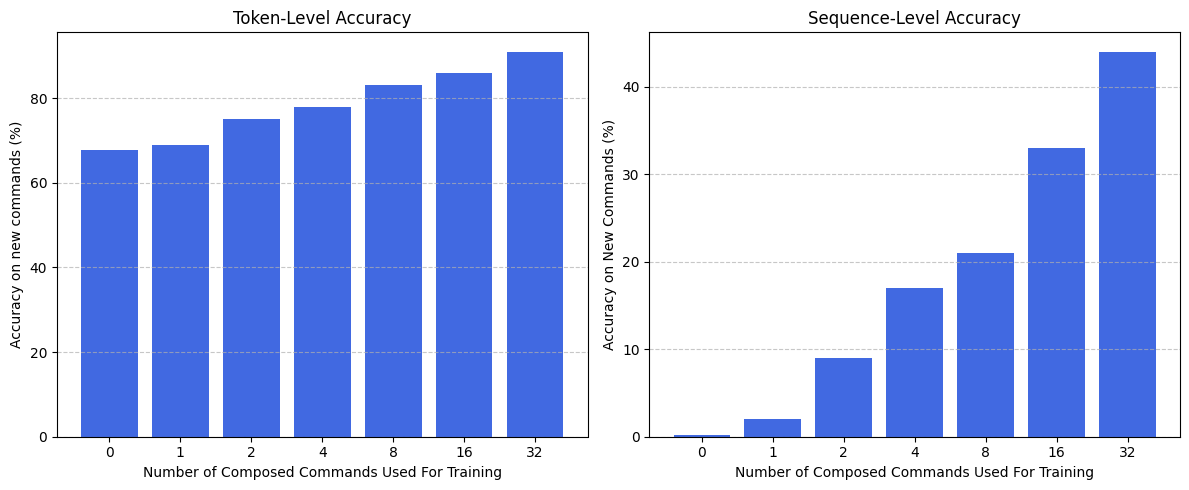

In [ ]:
plot_exp3_acc(aggregated_token_accuracies, aggregated_seq_accuracies)